# Transfer Learning with DenseNet121 to detect HLB


Transfer learning employing the database of leaves with and without HLB without the mask

Accessing to Google Drive and importing the libraries

In [3]:
from google.colab import drive
#drive.mount('/content/drive')


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

Time_start = datetime.now()
print("\n Start time:", Time_start)

# !pip install tensorflow
import tensorflow as tf
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory


#tf.compat.v1.disable_eager_execution()
#from keras.applications.vgg16 import VGG16
#from keras import backend as K
#import tensorflow.keras.backend as K

#from keras.applications.vgg16 import preprocess_input

#from keras.applications.vgg16 import decode_predictions
#K.clear_session()


 Start time: 2024-11-11 20:08:24.909506


Directories that are going to be used and number of elements by class in training and validation

In [4]:
ModelFolder = ('/content/drive/MyDrive/Research/HLB Classification/Arquitecturas/DenseNet121')
ImagesFolder = ('/content/drive/MyDrive/Research/HLB Classification/Database')
ImagesSplittedFolder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted')

Training_Folder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted/train')
Validation_Folder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted/val')



SubFolders_Training = os.listdir(Training_Folder)
print("Training images by category:")

for iSubFolder in range(len(SubFolders_Training)):
  CurrentFolder = os.path.join(Training_Folder, SubFolders_Training[iSubFolder])
  print(SubFolders_Training[iSubFolder], len(os.listdir(CurrentFolder)))

SubFolders_Validation = os.listdir(Validation_Folder)
print("\nValidation images by category:")

for iSubFolder in range(len(SubFolders_Validation)):
  CurrentFolder = os.path.join(Validation_Folder, SubFolders_Validation[iSubFolder])
  print(SubFolders_Validation[iSubFolder], len(os.listdir(CurrentFolder)))


Training images by category:
1 HLB 349
0 Sanas 273

Validation images by category:
1 HLB 88
0 Sanas 69


Definition of the training and validation datasets with the characteristics of the neural network

In [5]:
Batch_Size = 32
Img_Size = (224, 224)

Train_Dataset = image_dataset_from_directory(Training_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Validation_Dataset_Original = image_dataset_from_directory(Validation_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Found 622 files belonging to 2 classes.
Found 157 files belonging to 2 classes.


Verify the first 9 images and labels of the dataset

In [6]:
sorted(os.listdir(Training_Folder))

['0 Sanas', '1 HLB']

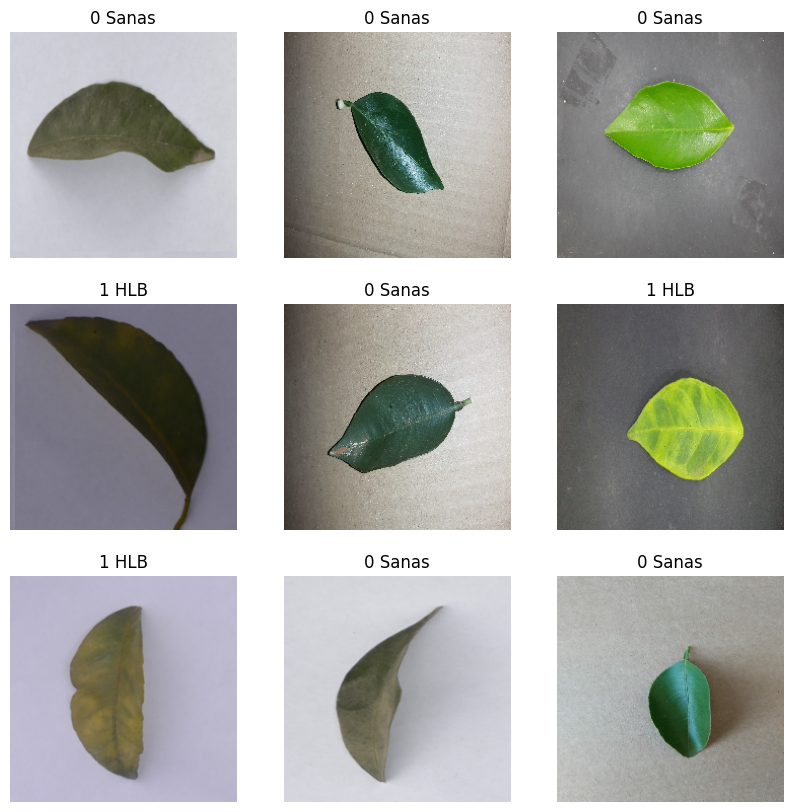

In [7]:
class_names = Train_Dataset.class_names

class_names = Train_Dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in Train_Dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.savefig(os.path.join(ModelFolder, '01 01 Imagenes Prueba.jpg'))


A test dataset is created.

Determine the validation dataset employing a lot of data batches *tf.data.experimental.cardinality*



In [8]:
val_batches = tf.data.experimental.cardinality(Validation_Dataset_Original)
test_dataset = Validation_Dataset_Original.take(val_batches // 5)
Validation_Dataset = Validation_Dataset_Original.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(Validation_Dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 4
Number of test batches: 1


In [9]:
Autotune = tf.data.AUTOTUNE

Train_Dataset = Train_Dataset.prefetch(buffer_size=Autotune)
Validation_Dataset = Validation_Dataset.prefetch(buffer_size=Autotune)
test_dataset = test_dataset.prefetch(buffer_size=Autotune)

Data augmented

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation([0, 0.99]),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.RandomZoom(height_factor = [-0.4, 0.4], width_factor=[-0.4, 0.4])])

Showing the augmented data

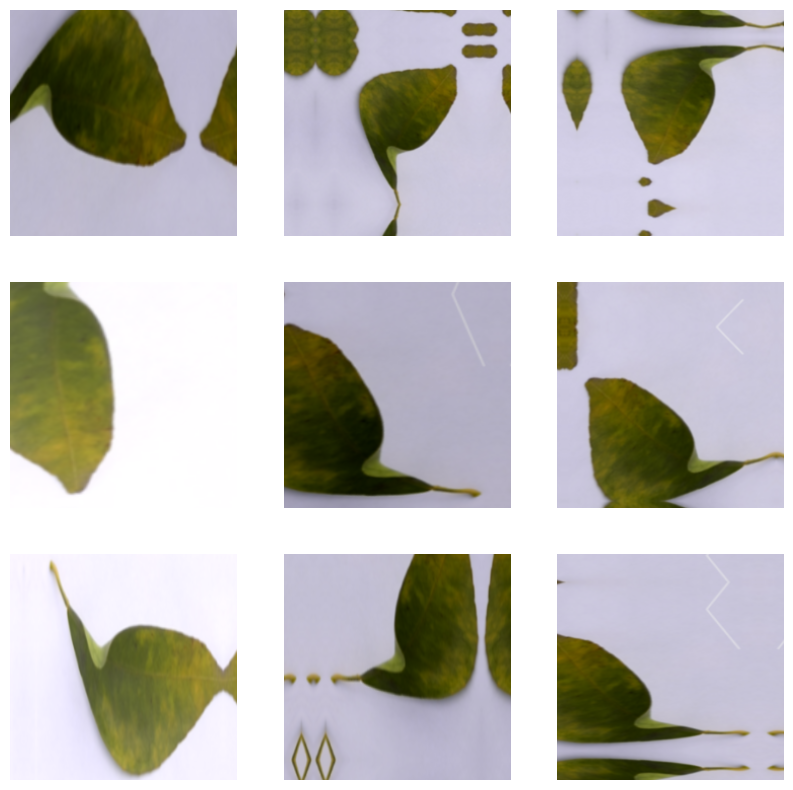

In [11]:
for image, _ in Train_Dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

plt.savefig(os.path.join(ModelFolder, '01 02 Augmented Images.jpg'))

Changing the **scale of the pixels values to use DenseNet121**

They should be between [-1 and 1], at this momment, they are between [0, 255]


In [12]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

#rescale = tf.keras.Sequential([layers.Rescaling(1./127.5, offset= -1)])
from tensorflow.keras import layers

rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255)
])

The *bottle neeck layer* is employed to preserve the characteristics with more generalities in comparition with the final layer of the MobilNet model.

The model is employed with the weights trained in ImageNet, when *include_top = false* as argument, the classification layers are not chaarged in the model

In [13]:
# Create the base model from the pre-trained model MobileNet V2
Img_Shape = Img_Size + (3,)
base_model = tf.keras.applications.DenseNet121(input_shape = Img_Shape,
                                               include_top = False,
                                               weights = 'imagenet')
image_batch, label_batch = next(iter(Train_Dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(32, 7, 7, 1024)


Feature extraction

Convolutional base created is frozen and used as a feature extractor. A classification is added at the top and trains the classificatior at the superior level (last layers).

Frozen of the convolutional base is realized with *layer.trainable = False* avoiding that the weights of a specific layer get refreshed during the training.


In [14]:
base_model.trainable = False


**Special note about *BatchNormalization* layers**

A lot of models contains *tf.keras.layers.BatchNormalization*, this is  special case and special warnings should be takenat fine tuning.

When *layer.trainable = False* is employed, BatchNormalization layers is going to execute as inference mode and is not going to refresh the average and variance statistics.

When a model with BatchNormalization layers is unfrozen to make a fine tuning, it should keep the BatchNormalization layers in inference employing *training = False* when is called the base model.

If this is not realized, the refresh applied to non trainable weights will destroy the learned by the model.

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

**Add a clasification header**


In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


Apply a *tf.keras.layers.Dense*  to convert characteristics in one single prediction per image.
An activation layer is not necessary here because this prediction will be treated as a logit or a prime prediction.

**Positive numbers predict the class 1, while negative numbers precict the class 0.**

In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build the chain model with the data augmented, scale change, *base_model* layers and extracting the characteristics employing the functional API Keras.

As previosly where mentioned, use *training = False* because our model has a BarchNormalization layer.

In [18]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compile the model**

Compile the model before trained. A binary lost cross entropy is employed with *from_logits = True* because we have two clases and a lineal output.

In [19]:
base_learning_rate = 0.0001
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#model.compile(keras.optimizers.SGD(), loss='mse') # CHECK IF LOSS 'mse' IS AN OPTION
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add (Add)                            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [20]:
len(model.trainable_variables)

2

**Training the model**

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(Validation_Dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(Train_Dataset,
                    epochs=initial_epochs,
                    callbacks=[callback],
                    validation_data=Validation_Dataset_Original)



4/4 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step - accuracy: 0.4949 - loss: 0.8019
initial loss: 0.86
initial accuracy: 0.46
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 225s 10s/step - accuracy: 0.4581 - loss: 0.9381 - val_accuracy: 0.4650 - val_loss: 0.6829
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 254s 10s/step - accuracy: 0.4824 - loss: 0.7589 - val_accuracy: 0.5860 - val_loss: 0.6136
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 200s 10s/step - accuracy: 0.5287 - loss: 0.7340 - val_accuracy: 0.6497 - val_loss: 0.5968
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 195s 10s/step - accuracy: 0.5713 - loss: 0.6825 - val_accuracy: 0.7070 - val_loss: 0.5862
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 206s 10s/step - accuracy: 0.5488 - loss: 0.6875 - val_accuracy: 0.7134 - val_loss: 0.5748
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 10s/step - accuracy: 0.5607 - loss: 0.6937 - val_accuracy: 0.7261 - val_loss: 0.5606
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 196s 9s/step - accuracy: 0.5569 - loss: 0.7162 - val_accuracy: 0.7325 - val_loss

In [22]:
# First Training Time
First_Training = datetime.now()

print("\n Start time:", Time_start)
print("\n End time of the first training:", First_Training)
print('\n Duration: {}'.format(First_Training - Time_start))


 Start time: 2024-11-11 20:08:24.909506

 End time of the first training: 2024-11-11 20:46:36.698433

 Duration: 0:38:11.788927


**Learning Curves**

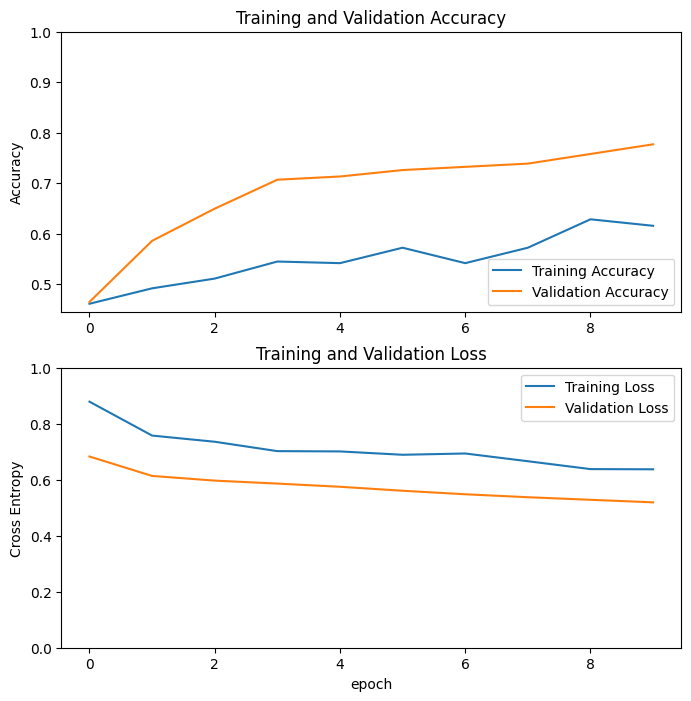

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.savefig(os.path.join(ModelFolder, '01 03 Training and Validation Accuracy.jpg'))


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(os.path.join(ModelFolder, '01 03 Learning Curves.jpg'))
plt.show()


In [24]:
os.chdir(ModelFolder)
model.save('01_DenseNet121_NoFineTuning.keras')

# Fine Tuning

We are going to tune:

*   Learning rate
*   No. of epochs

We are going to unfreeze top layers of the model



In [25]:
# Setting the top layers as trainable
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# This step improves the accuracy of the model by a few steps
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
#              metrics=['accuracy'])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

#model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#              loss=keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=[keras.metrics.BinaryAccuracy()])

Number of layers in the base model:  427


Compile the model

In [26]:
model.summary()

len(model.trainable_variables)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add (Add)                            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,150,209 (23.46 MB)

 Non-trainable params: 888,320 (3.39 MB)

281

Continue with the training model

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(Train_Dataset,
                         epochs=total_epochs,
                         callbacks=[callback],
                         initial_epoch=history.epoch[-1],
                         validation_data=Validation_Dataset_Original)


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 427s 17s/step - accuracy: 0.6246 - loss: 0.6938 - val_accuracy: 0.8025 - val_loss: 0.4416
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 383s 17s/step - accuracy: 0.7068 - loss: 0.5652 - val_accuracy: 0.8535 - val_loss: 0.3892
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 376s 17s/step - accuracy: 0.7814 - loss: 0.4931 - val_accuracy: 0.8662 - val_loss: 0.3509
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 381s 17s/step - accuracy: 0.8121 - loss: 0.4233 - val_accuracy: 0.8854 - val_loss: 0.3099
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 386s 17s/step - accuracy: 0.8602 - loss: 0.3723 - val_accuracy: 0.9045 - val_loss: 0.2704
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 373s 17s/step - accuracy: 0.8735 - loss: 0.3121 - val_accuracy: 0.9236 - val_loss: 0.2427
Epoch 16/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 357s 18s/step - accuracy: 0.8975 - loss: 0.2897 - val_accuracy: 0.9236 - val_loss: 0.2140
Epoch 17/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 369s 17s/step - accuracy: 0.9131 - loss: 0.2624 - val_accu

In [28]:
# Fine Tuning Training Time
Fine_Tuning_Time = datetime.now()

print("\n Start time:", Time_start)
print("\n End time of the first training:", First_Training)
print("\n End time of the fine tuning training:", Fine_Tuning_Time)
print('\n Duration of the fine tuning training: {}'.format(Fine_Tuning_Time - First_Training))


 Start time: 2024-11-11 20:08:24.909506

 End time of the first training: 2024-11-11 20:46:36.698433

 End time of the fine tuning training: 2024-11-11 21:57:18.020605

 Duration of the fine tuning training: 1:10:41.322172


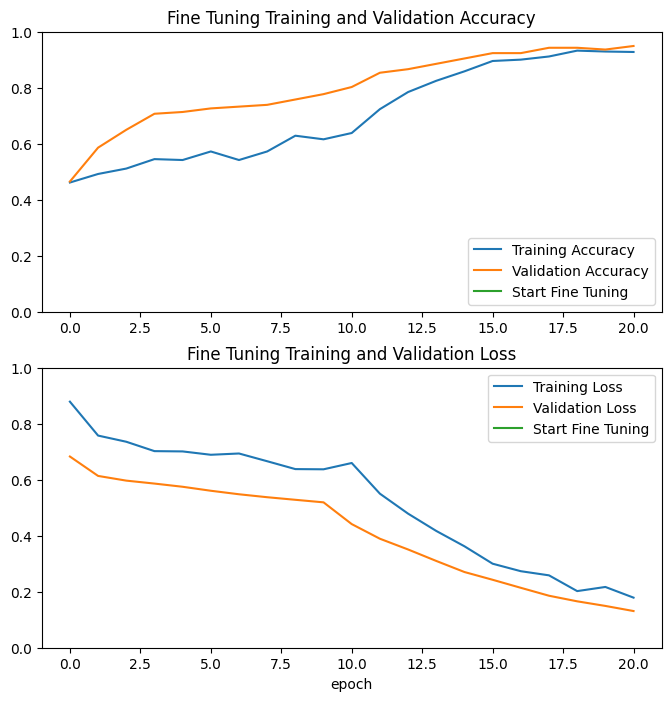

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs,initial_epochs],
         #plt.ylim(),  color = 'red',
         label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Fine Tuning Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         #plt.ylim(), color = 'red',
         label='Start Fine Tuning') # CHANGE COLOR TO RED OR SOMETHING
plt.legend(loc='upper right')
plt.title('Fine Tuning Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(os.path.join(ModelFolder, '01 04 Learning Curves Fine Tuning.jpg'))
plt.show()

In [30]:
model.save('01_DenseNet121_FineTuning.keras')